In [ ]:
%load_ext autoreload
%autoreload 2

In [458]:
from dataset import FakeDatasetIsPlanar
from visualization import visualize

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import OneHotDegree
from torch_geometric.datasets import FakeDataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch import nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import torch
import random
import numpy as np


# Dataset

In [210]:
help(FakeDatasetIsPlanar.__init__)

Help on function __init__ in module dataset.planar:

__init__(self, num_graphs: int, avg_num_nodes: int = 1000, avg_degree: int = 10, edge_dim: int = 0, is_undirected: bool = True, transform: Optional[Callable] = None, pre_transform: Optional[Callable] = None, **kwargs)



In [420]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 4
max_degree = avg_degree * 5 // 2

one_hot_degree = OneHotDegree(max_degree, cat=False)

ds_small = FakeDatasetIsPlanar(num_graphs=10000, avg_num_nodes=8, avg_degree=avg_degree,
                               transform=one_hot_degree)
print(f"Planar graphs: {int(ds_small.y.sum())}")
ds_small

Planar graphs: 2193
CPU times: user 2.55 s, sys: 4.29 ms, total: 2.55 s
Wall time: 2.57 s


FakeDatasetIsPlanar(10000)

In [395]:
ds_small[100]

Data(edge_index=[2, 44], y=[1], is_planar=[1], pos=[10, 2], num_nodes=10, x=[10, 11])

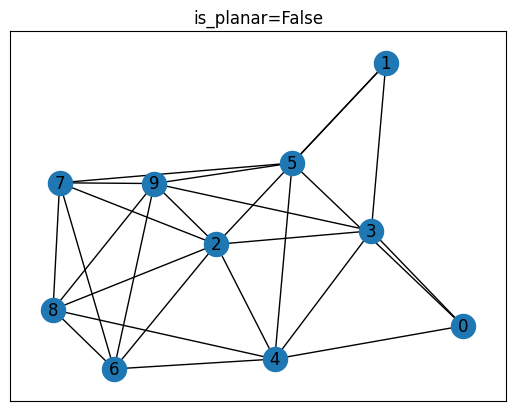

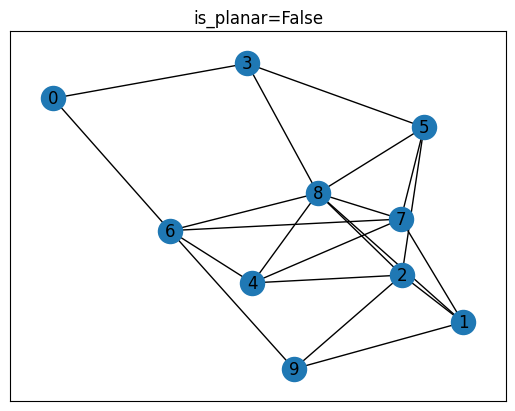

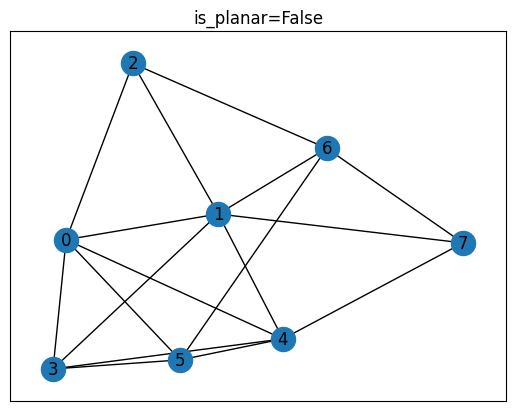

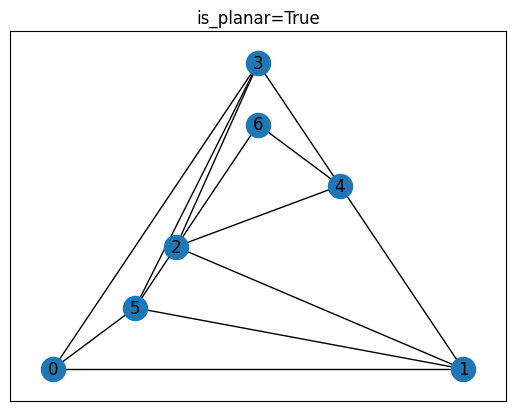

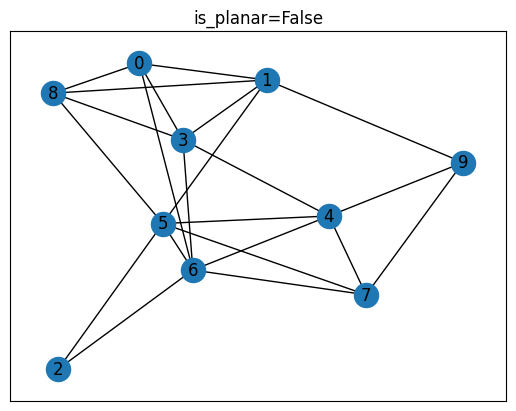

In [421]:
for data in ds_small[:5]:
    visualize(data)
    plt.show()

# Train a simple 3-layer GNN with a final average pooling

The model code is taken from "Graph Classification" example https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html

In [422]:
ds_small_shuffled = ds_small.shuffle()
N = len(ds_small)
train_count = int(N*0.8)
train_ds_small = ds_small_shuffled[:train_count]
test_ds_small = ds_small_shuffled[train_count:]

print(f'Number of training graphs: {len(train_ds_small)}')
print(f'Number of test graphs: {len(test_ds_small)}')

Number of training graphs: 8000
Number of test graphs: 2000


In [434]:
train_loader = DataLoader(train_ds_small, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds_small, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2376], y=[64], is_planar=[64], pos=[522, 2], num_nodes=522, x=[522, 11], batch=[522], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2256], y=[64], is_planar=[64], pos=[511, 2], num_nodes=511, x=[511, 11], batch=[511], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2268], y=[64], is_planar=[64], pos=[507, 2], num_nodes=507, x=[507, 11], batch=[507], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2266], y=[64], is_planar=[64], pos=[502, 2], num_nodes=502, x=[502, 11], batch=[502], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2394], y=[64], is_planar=[64], pos=[518, 2], num_nodes=518, x=[518, 11], batch=[518], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2252], y=[64], is_planar=[64], pos=[507, 2], num_nodes=507, x=[50

In [398]:
class GCN(nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=11, num_node_features=ds_small.num_node_features,
           num_classes=ds_small.num_classes)
print(model)

GCN(
  (conv1): GCNConv(11, 11)
  (conv2): GCNConv(11, 11)
  (conv3): GCNConv(11, 11)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)


In [435]:
model = GCN(hidden_channels=11, num_node_features=ds_small.num_node_features,
           num_classes=ds_small.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     tp = 0
     fn = 0
     fp = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         tp += int((pred == data.y).sum())  # Check against ground-truth labels.
         fn += int(((pred == 0)*(data.y == 1)).sum())
         fp += int(((pred == 1)*(data.y == 0)).sum())

     total = len(loader.dataset)
     accuracy = tp / total
     precision = tp / (tp + fp)
     recall = tp / (tp + fn)
     f1 = 2*recall*precision / (recall + precision)
     return accuracy, precision, recall, total, f1
     
    
def fmt(accuracy, precision, recall, total, f1):
    return f"accuracy={accuracy:.4f}, precision={precision:.4f}, recall={recall:.4f}, f1={f1:.4f}, size={total}"

train_metrics_per_epoch = []
test_metrics_per_epoch = []

for epoch in range(1, 100):
    train()
    train_metrics = test(train_loader)
    test_metrics = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train: {fmt(*train_metrics)}, Test: {fmt(*test_metrics)}')
    train_metrics_per_epoch.append(train_metrics)
    test_metrics_per_epoch.append(test_metrics)

Epoch: 001, Train: accuracy=0.9180, precision=0.9673, recall=0.9474, f1=0.9572, size=8000, Test: accuracy=0.9135, precision=0.9656, recall=0.9442, f1=0.9548, size=2000
Epoch: 002, Train: accuracy=0.9181, precision=0.9357, recall=0.9800, f1=0.9573, size=8000, Test: accuracy=0.9165, precision=0.9323, recall=0.9818, f1=0.9564, size=2000
Epoch: 003, Train: accuracy=0.9183, precision=0.9725, recall=0.9428, f1=0.9574, size=8000, Test: accuracy=0.9115, precision=0.9702, recall=0.9378, f1=0.9537, size=2000
Epoch: 004, Train: accuracy=0.9435, precision=0.9772, recall=0.9647, f1=0.9709, size=8000, Test: accuracy=0.9365, precision=0.9705, recall=0.9640, f1=0.9672, size=2000
Epoch: 005, Train: accuracy=0.9364, precision=0.9668, recall=0.9675, f1=0.9671, size=8000, Test: accuracy=0.9345, precision=0.9659, recall=0.9664, f1=0.9661, size=2000
Epoch: 006, Train: accuracy=0.9419, precision=0.9661, recall=0.9740, f1=0.9701, size=8000, Test: accuracy=0.9375, precision=0.9630, recall=0.9725, f1=0.9677, si

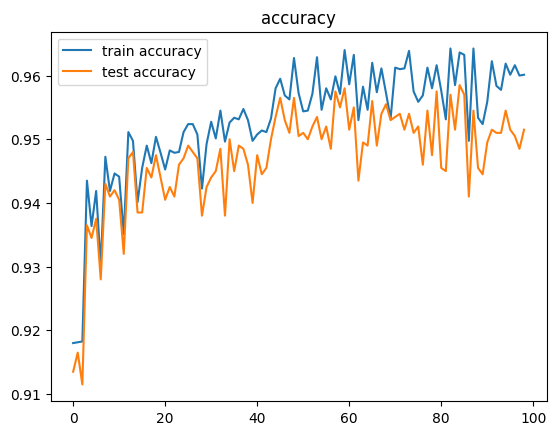

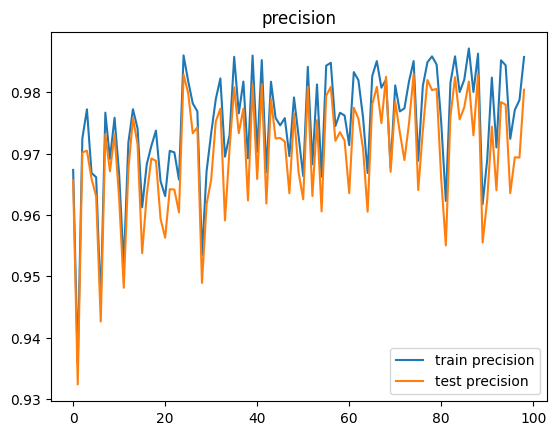

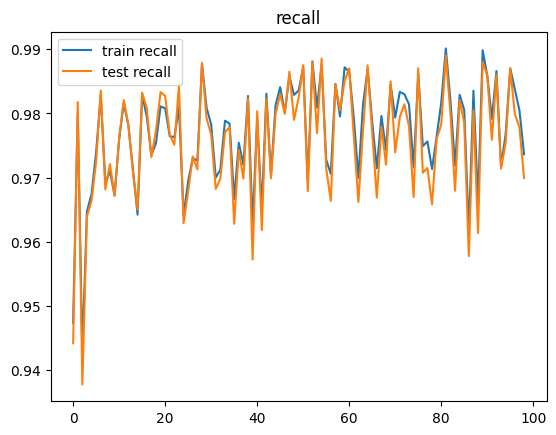

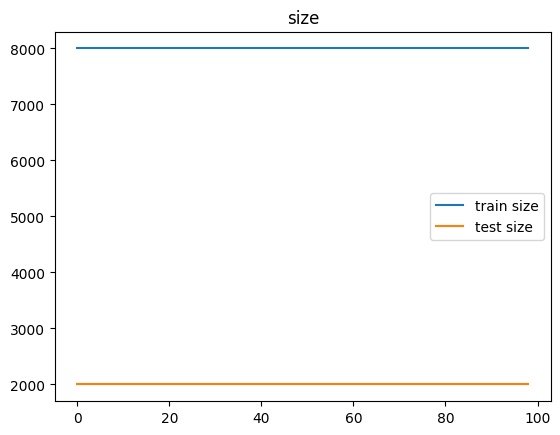

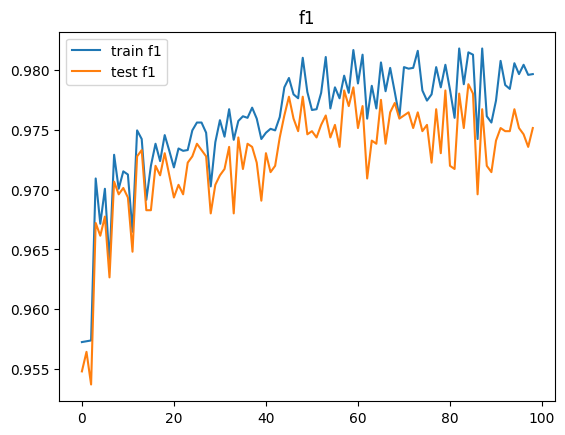

In [436]:
for metric_idx, metric_name in enumerate(['accuracy', 'precision', 'recall', 'size', 'f1']):
    plt.plot([t[metric_idx] for t in train_metrics_per_epoch], label=f'train {metric_name}')
    plt.plot([t[metric_idx] for t in test_metrics_per_epoch], label=f'test {metric_name}')
    plt.title(metric_name)
    plt.legend()
    plt.show()


# Train on 100k dataset

In [ ]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 4
max_degree = avg_degree * 5 // 2

one_hot_degree = OneHotDegree(max_degree, cat=False)

ds_100k = FakeDatasetIsPlanar(num_graphs=100000, avg_num_nodes=8, avg_degree=avg_degree,
                              transform=one_hot_degree)
print(f"Planar graphs: {int(ds_100k.y.sum())}")
ds_100k

....

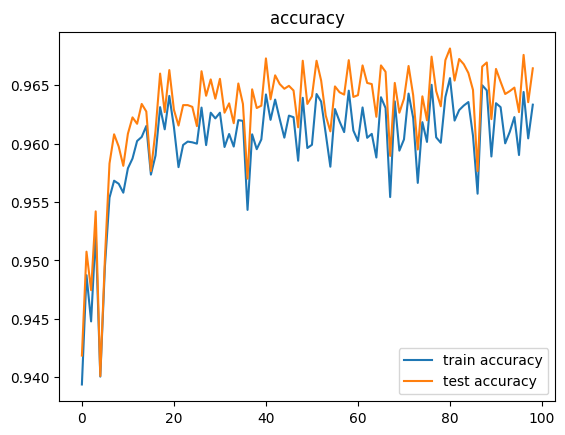

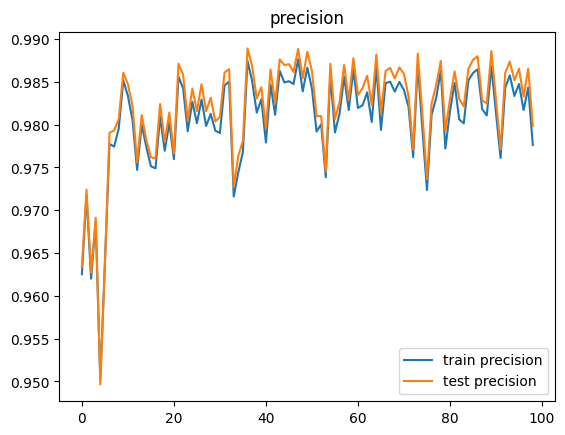

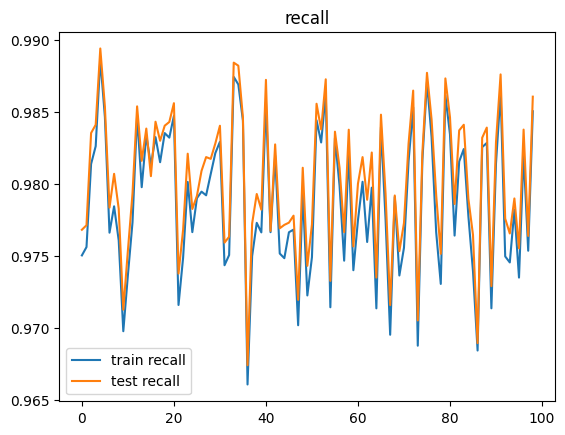

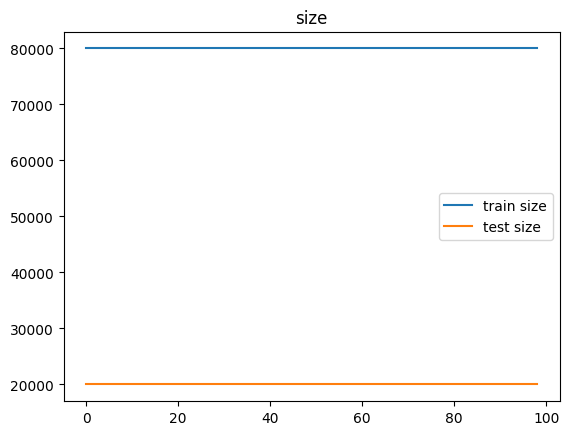

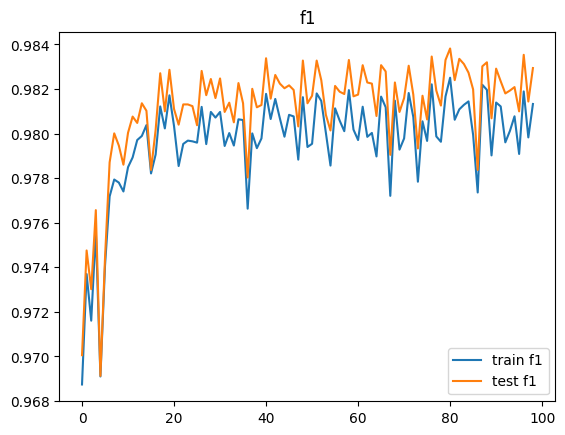

In [440]:
for metric_idx, metric_name in enumerate(['accuracy', 'precision', 'recall', 'size', 'f1']):
    plt.plot([t[metric_idx] for t in train_metrics_per_epoch], label=f'train {metric_name}')
    plt.plot([t[metric_idx] for t in test_metrics_per_epoch], label=f'test {metric_name}')
    plt.title(metric_name)
    plt.legend()
    plt.show()


# Train on 1mln dataset

In [441]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 4
max_degree = avg_degree * 5 // 2

one_hot_degree = OneHotDegree(max_degree, cat=False)

ds_100k = FakeDatasetIsPlanar(num_graphs=1000000, avg_num_nodes=8, avg_degree=avg_degree,
                              transform=one_hot_degree)
print(f"Planar graphs: {int(ds_100k.y.sum())}")
ds_100k

Planar graphs: 216652
CPU times: user 4min 6s, sys: 1.08 s, total: 4min 7s
Wall time: 4min 8s


FakeDatasetIsPlanar(1000000)

In [442]:
ds_100k_shuffled = ds_100k.shuffle()
N = len(ds_100k)
train_count = int(N*0.8)
train_ds = ds_100k_shuffled[:train_count]
test_ds = ds_100k_shuffled[train_count:]

print(f'Number of training graphs: {len(train_ds)}')
print(f'Number of test graphs: {len(test_ds)}')

Number of training graphs: 800000
Number of test graphs: 200000


In [443]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2220], y=[64], is_planar=[64], pos=[497, 2], num_nodes=497, x=[497, 11], batch=[497], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2142], y=[64], is_planar=[64], pos=[498, 2], num_nodes=498, x=[498, 11], batch=[498], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2254], y=[64], is_planar=[64], pos=[510, 2], num_nodes=510, x=[510, 11], batch=[510], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2382], y=[64], is_planar=[64], pos=[522, 2], num_nodes=522, x=[522, 11], batch=[522], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2212], y=[64], is_planar=[64], pos=[504, 2], num_nodes=504, x=[504, 11], batch=[504], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2204], y=[64], is_planar=[64], pos=[498, 2], num_nodes=498, x=[49

In [444]:
model = GCN(hidden_channels=11, num_node_features=ds_small.num_node_features,
           num_classes=ds_small.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     tp = 0
     fn = 0
     fp = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         tp += int((pred == data.y).sum())  # Check against ground-truth labels.
         fn += int(((pred == 0)*(data.y == 1)).sum())
         fp += int(((pred == 1)*(data.y == 0)).sum())

     total = len(loader.dataset)
     accuracy = tp / total
     precision = tp / (tp + fp)
     recall = tp / (tp + fn)
     f1 = 2*recall*precision / (recall + precision)
     return accuracy, precision, recall, total, f1

def fmt(accuracy, precision, recall, total, f1):
    return f"accuracy={accuracy:.4f}, precision={precision:.4f}, recall={recall:.4f}, f1={f1:.4f}, size={total}"

train_metrics_per_epoch = []
test_metrics_per_epoch = []

for epoch in range(1, 100):
    train()
    train_metrics = test(train_loader)
    test_metrics = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train: {fmt(*train_metrics)}, Test: {fmt(*test_metrics)}')
    train_metrics_per_epoch.append(train_metrics)
    test_metrics_per_epoch.append(test_metrics)

Epoch: 001, Train: accuracy=0.9626, precision=0.9859, recall=0.9760, f1=0.9809, size=800000, Test: accuracy=0.9624, precision=0.9856, recall=0.9761, f1=0.9808, size=200000
Epoch: 002, Train: accuracy=0.9637, precision=0.9843, recall=0.9787, f1=0.9815, size=800000, Test: accuracy=0.9634, precision=0.9842, recall=0.9785, f1=0.9814, size=200000
Epoch: 003, Train: accuracy=0.9658, precision=0.9828, recall=0.9824, f1=0.9826, size=800000, Test: accuracy=0.9657, precision=0.9827, recall=0.9825, f1=0.9826, size=200000
Epoch: 004, Train: accuracy=0.9659, precision=0.9855, recall=0.9799, f1=0.9827, size=800000, Test: accuracy=0.9655, precision=0.9853, recall=0.9796, f1=0.9824, size=200000
Epoch: 005, Train: accuracy=0.9653, precision=0.9861, recall=0.9786, f1=0.9823, size=800000, Test: accuracy=0.9651, precision=0.9859, recall=0.9786, f1=0.9823, size=200000
Epoch: 006, Train: accuracy=0.9634, precision=0.9859, recall=0.9768, f1=0.9814, size=800000, Test: accuracy=0.9629, precision=0.9856, recall

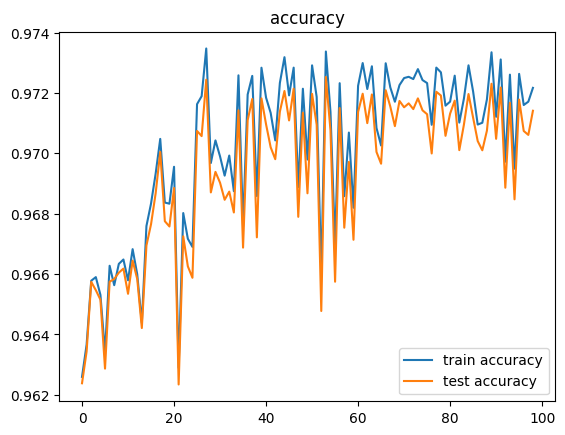

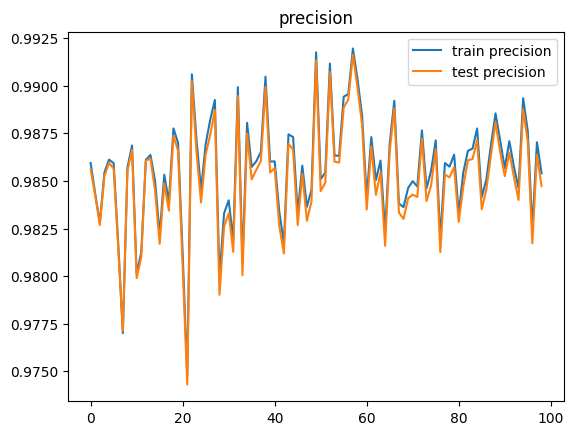

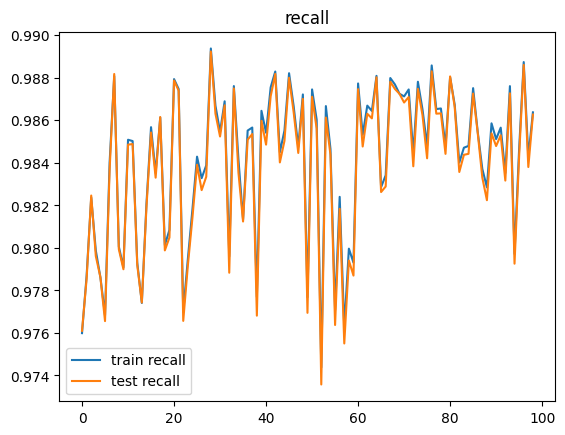

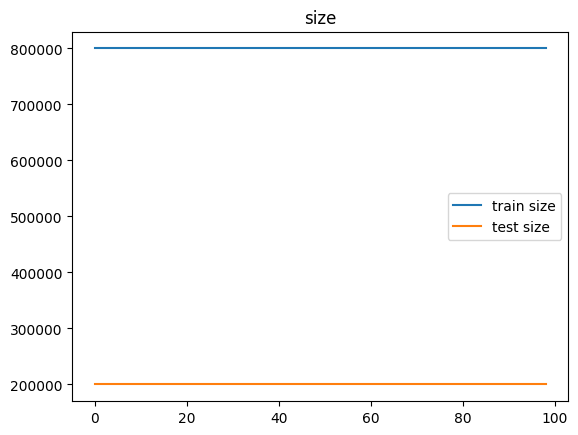

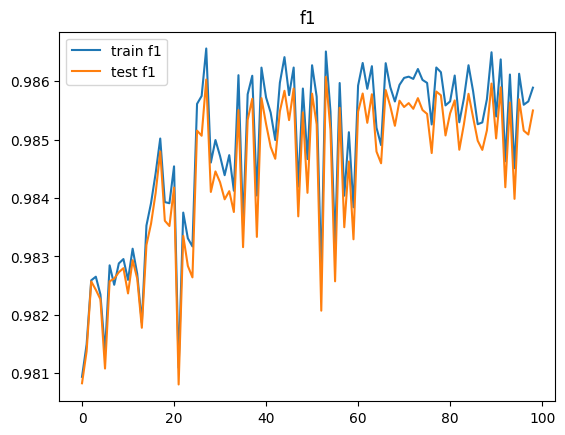

In [445]:
for metric_idx, metric_name in enumerate(['accuracy', 'precision', 'recall', 'size', 'f1']):
    plt.plot([t[metric_idx] for t in train_metrics_per_epoch], label=f'train {metric_name}')
    plt.plot([t[metric_idx] for t in test_metrics_per_epoch], label=f'test {metric_name}')
    plt.title(metric_name)
    plt.legend()
    plt.show()


# Conclusion

F1 metric converges after ~60 epoch to 0.985 on the 1mln dataset and to 0.982 on the 100k dataset. Accuracy is ~97% Metrics doesn't show any signs of overfitting.

Subjectively, it's unexpectedly good.

Questions:
1. Is the dataset too simple? May the task be solved without using the graph structure?
2. Will the quality grow when making the model more complex?

# Solving the task without graph structure - 1mln dataset

In [449]:
ds_mln = ds_100k
ds_mln

FakeDatasetIsPlanar(1000000)

In [455]:
ds_mln_shuffled = ds_mln.shuffle()
N = len(ds_mln)
train_count = int(N*0.8)
train_ds = ds_mln_shuffled[:train_count]
test_ds = ds_mln_shuffled[train_count:]

print(f'Number of training graphs: {len(train_ds)}')
print(f'Number of test graphs: {len(test_ds)}')

Number of training graphs: 800000
Number of test graphs: 200000


In [456]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



# Playground 

In [446]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
input, target, output

(tensor([[-0.3297, -0.5076,  0.1272, -1.9410,  0.9745],
         [ 2.5379, -0.4932,  0.3459,  1.4914, -1.0471],
         [ 0.7523,  0.5318, -0.7590, -2.3480,  0.9214]], requires_grad=True),
 tensor([2, 2, 2]),
 tensor(2.2815, grad_fn=<NllLossBackward0>))

In [447]:
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
input, target, output

(tensor([[ 1.2327,  0.9486, -1.1305,  0.1144,  0.0027],
         [ 0.7236,  1.0347,  2.4844,  0.2751, -0.2842],
         [-1.3363,  0.6833,  0.8286,  0.4334, -1.7989]], requires_grad=True),
 tensor([[0.0554, 0.1074, 0.0277, 0.2576, 0.5519],
         [0.1011, 0.2058, 0.2219, 0.0740, 0.3972],
         [0.1748, 0.1656, 0.3804, 0.1505, 0.1287]]),
 tensor(1.9882, grad_fn=<DivBackward1>))